In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/NLP/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate, Input, Reshape, Conv2D, Dropout, Conv1D, CuDNNLSTM, CuDNNGRU, Bidirectional
from keras.models import Model, load_model

from keras.layers.core import *
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
import keras.backend as K
from keras import optimizers
import keras

In [3]:
!pip install keras-self-attention

In [0]:
from keras_self_attention import SeqSelfAttention

In [0]:
def create_data(file):
  text = file.read()
  fields = ['#','$','%', '^','&','*','@','/','//','\\','[',']','(',')']
  entries = [j.split('\n') for j in text.split('\n\n')]
  data = {'text':[], 'lang':[], 'tag':[]}
  for entry in entries:
    sent = entry[0].split('\t')[-1]
    if sent == 'positive':
      data['tag'].append(0)
    elif sent=='negative':
      data['tag'].append(1)
    else:
      data['tag'].append(2)
    words = []
    langs = []
    for wordl in entry[1:]:
      word, lang = wordl.split('\t')
      if word not in fields:
        words.append(word)
        langs.append(lang)
    data['text'].append(' '.join(words))
    data['lang'].append(' '.join(langs))
  return data

In [0]:
with open(datapath+'train.txt', 'r') as f:
  trainval = create_data(f)
with open(datapath+'test.txt', 'r') as f:
  test = create_data(f)

In [0]:
test = pd.DataFrame(test)
trainval = pd.DataFrame(trainval)

In [0]:
SPLIT = 0.1
MAXLEN_WORD = 128
MAXLEN_SENT = 64
EMB_FEATURES = 256

In [0]:
train, val = train_test_split(trainval, test_size = SPLIT, random_state = 42)

In [0]:
tokenizer_lang = Tokenizer(num_words=4, filters='')
tokenizer_lang.fit_on_texts(train['lang'])

In [0]:
tokenizer_text = Tokenizer(num_words=256, filters='', char_level=True)
tokenizer_text.fit_on_texts(train['text'])

In [0]:
def create_3d_data(data, tokenizer_text, tokenizer_lang, MAXLEN_WORD, MAXLEN_SENT):
  X_text = sequence.pad_sequences(tokenizer_text.texts_to_sequences(data['text']), maxlen=MAXLEN_SENT*MAXLEN_WORD)
  X_lang = sequence.pad_sequences(tokenizer_lang.texts_to_sequences(data['lang']), maxlen=MAXLEN_SENT)
  Y = np_utils.to_categorical(np.array(data['tag']), 3)
  return X_text, X_lang, Y

In [0]:
X_text_train, X_lang_train, Y_train = create_3d_data(train, tokenizer_text, tokenizer_lang, MAXLEN_WORD, MAXLEN_SENT)
X_text_val, X_lang_val, Y_val = create_3d_data(val, tokenizer_text, tokenizer_lang, MAXLEN_WORD, MAXLEN_SENT)

In [0]:
X_text_test, X_lang_test, Y_test = create_3d_data(test, tokenizer_text, tokenizer_lang, MAXLEN_WORD, MAXLEN_SENT)

In [25]:
print(X_text_train.shape, X_lang_train.shape, Y_train.shape)

(13618, 8192) (13618, 64) (13618, 3)


In [33]:
print(X_text_test.shape, X_lang_test.shape, Y_test.shape)

(1870, 8192) (1870, 64) (1870, 3)


In [26]:
np.max(X_text_train)

255

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
# Model
text = Input(shape=(64*128,))
lang = Input(shape=(64,))

#Embedding for text
emb_text = Embedding(EMB_FEATURES+3, 128, input_length=64*128)(text)

conv = Conv1D(512, 3, activation='tanh')(emb_text)


lstm = Bidirectional(CuDNNGRU(128, return_sequences=True))(conv)


def max_1d(X):
    return K.mean(X, axis=-1)

att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention')(lstm)

out_lstm = Bidirectional(CuDNNGRU(128))(lstm)

dense_1 = Dense(500, activation='relu')(out_lstm)
drop = Dropout(0.15)(dense_1)
dense = Dense(200, activation='relu')(drop)
out = Dense(3, activation='sigmoid')(dense)

print(out.shape)
adam = optimizers.Adam(lr=0.001, decay=1e-6)

model_2 = Model(inputs=[text, lang], output=[out])
model_2.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 3)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [18]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8192)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 8192, 128)         33152     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8190, 512)         197120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8190, 256)         493056    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0   

In [0]:
filepath = datapath+"model_HAR.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
history_2 = model_2.fit([X_text_train, X_lang_train], 
                    y=Y_train, 
                    batch_size=32,
                    epochs=30, 
                    validation_data=([X_text_val, X_lang_val], Y_val), callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 13618 samples, validate on 1514 samples
Epoch 1/30





13618/13618 [==============================] - 1945s 143ms/step - loss: 1.0882 - acc: 0.3750 - f1_m: 0.4810 - precision_m: 0.3512 - recall_m: 0.7801 - val_loss: 1.0779 - val_acc: 0.3930 - val_f1_m: 0.5130 - val_precision_m: 0.3539 - val_recall_m: 0.9326

Epoch 00001: val_loss improved from inf to 1.07795, saving model to /content/gdrive/My Drive/NLP/model_HAR.h5
Epoch 2/30
13618/13618 [==============================] - 1940s 142ms/step - loss: 1.0792 - acc: 0.3904 - f1_m: 0.5069 - precision_m: 0.3478 - recall_m: 0.9384 - val_loss: 1.0774 - val_acc: 0.3910 - val_f1_m: 0.5095 - val_precision_m: 0.3471 - val_recall_m: 0.9577

Epoch 00002: val_loss improved from 1.07795 to 1.07744, saving model to /content/gdrive/My Drive/NLP/model_HAR.h5
Epoch 3/30
13618/13618 [==============================] - 1939s 142ms/step - loss: 1.0754 - a

KeyboardInterrupt: ignored

In [0]:
plt.plot(history_2.history['f1_m'])
plt.plot(history_2.history['val_f1_m'])

In [0]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

In [30]:
#load the model
dependencies = {
    'f1_m':f1_m,
    'precision_m':precision_m,
    'recall_m':recall_m
}
new_model = load_model(datapath+"model_HAR.h5", custom_objects=dependencies)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
pred = new_model.predict(X_text_test, batch_size=32)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report \n: ", 
    classification_report(y_test, y_pred)) 

In [41]:
cal_accuracy([np.argmax(j) for j in Y_test], [np.argmax(j) for j in pred])

Confusion Matrix: 
 [[292 155 135]
 [ 66 378  89]
 [181 350 224]]
Accuracy :  47.80748663101605
Report 
:                precision    recall  f1-score   support

           0       0.54      0.50      0.52       582
           1       0.43      0.71      0.53       533
           2       0.50      0.30      0.37       755

    accuracy                           0.48      1870
   macro avg       0.49      0.50      0.48      1870
weighted avg       0.49      0.48      0.46      1870



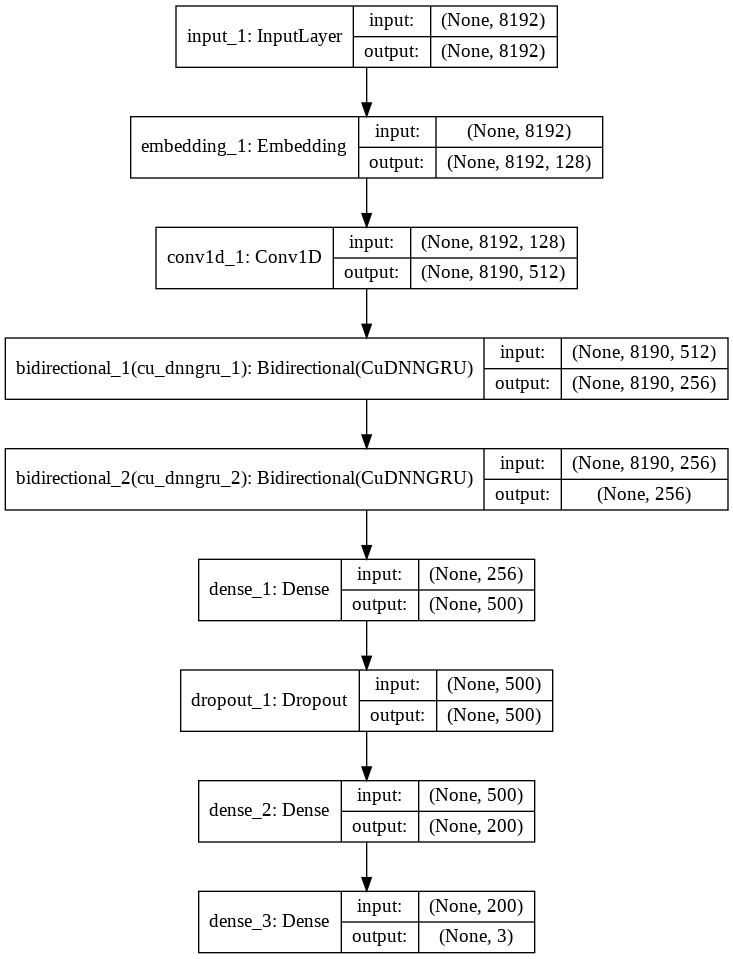

In [43]:
from keras.utils import plot_model
plot_model(new_model, to_file=datapath+'model.png', show_shapes=True)